In [1]:
import altair as alt
from pathlib import Path
import json
import pandas as pd
import numpy as np
import altair_viewer

alt.renderers.enable('altair_viewer', inline=True)

RendererRegistry.enable('altair_viewer')

# Process Data

In [2]:
results = {
    'no-static': ('../asplos_data/no-static/data.csv', '../asplos_data/no-static/sim.csv'),
    'static': ('../asplos_data/static/data.csv', '../asplos_data/static/sim2.csv'),
    'unrolled': ('../asplos_data/unrolled/data.csv', '../asplos_data/unrolled/sim.csv'),
    'fixed-static': ('../asplos_data/fixed-static/data3.csv', '../asplos_data/fixed-static/sim3.csv'),
    'fixed-no-static': ('../asplos_data/fixed-no-static/data3.csv', '../asplos_data/fixed-no-static/sim2.csv'),
    'fixed-unrolled': ('../asplos_data/fixed-unrolled/data2.csv', '../asplos_data/fixed-unrolled/sim2.csv')
#     'no-static': ('../results/17_09_51-08_2020/data.csv', '../results/17_09_51-08_2020/sim.csv'),
#     'static': ('../results/14_15_10-08_2020/data.csv', '../results/14_15_10-08_2020/sim2.csv'),
#     'unrolled': ('../results/14_17_26-08_2020/data.csv', '../results/14_17_26-08_2020/sim.csv'),
#     'fixed-static': ("../results/18_12_10-08_2020/data3.csv", "../results/14_15_10-08_2020/sim3.csv"),
#     'fixed-no-static': ("../results/18_12_51-08_2020/data3.csv", "../results/17_09_51-08_2020/sim2.csv"),
#     'fixed-unrolled': ('../results/18_16_38-08_2020/data2.csv', '../results/18_16_38-08_2020/sim2.csv'),
}
data_lib = {}
fontsize=16

for k, v in results.items():
    futil_hls_data = pd.read_csv(v[0])
    futil_latency = pd.read_csv(v[1])
    futil_hls_data = futil_hls_data[futil_hls_data['type'] != 'hls_total']
    for _, row in futil_latency.iterrows():
        bench_filt = futil_hls_data['benchmark'] == row[0]
        type_filt = futil_hls_data['type'] == 'futil'
        futil_hls_data.loc[(bench_filt) & (type_filt), 'latency'] = row[1]
    futil_hls_data = futil_hls_data.sort_values(by='benchmark').reset_index(drop=True)
    futil_hls_data['benchmark'] = futil_hls_data['benchmark'].apply(lambda x: x.split('-')[-1])
    data_lib[k] = futil_hls_data


# Timed Futil vs VHLS Graph

In [3]:
# Generate merged and normalized data for types of benchmarks
import math
merged = {}
KEYS = ['lut', 'latency']

for key in data_lib.keys():
    df = data_lib[key]
    hls = df[df['type'] == 'hls'][['benchmark'] + KEYS]
    futil = df[df['type'] == 'futil'][['benchmark'] + KEYS]
    # Merge the HLS and FuTIL data
    combined = hls.merge(futil, on='benchmark', suffixes = ['-hls', '-futil'])
    # Calculate normalized keys for KEYS
    for norm_key in KEYS:
        combined[f'{norm_key}-norm'] = combined[f'{norm_key}-futil'] / combined[f'{norm_key}-hls']
        
    merged[key] = combined
    
order = [
    '2mm', 
    '3mm', 
    'atax',
    'doitgen',
    'gemm',
    'gemver',
    'gesummv',
    'gramschmidt',
    'mvt',
    'syr2k', 
    'syrk',
    'bicg',
    'cholesky',
    'durbin',
    'lu',
    'ludcmp',
    'symm',
    'trisolv', 
    'trmm'
]

In [4]:
df1 = merged['fixed-static']
df2 = merged['fixed-no-static']
df3 = merged['fixed-unrolled']
df1['benchmark'] = pd.Categorical(df1['benchmark'], order)
df2['benchmark'] = pd.Categorical(df2['benchmark'], order)
df3['benchmark'] = pd.Categorical(df3['benchmark'], order)
df1['type'] = 'Latency Sensitive'
df2['type'] = 'Latency Insensitive'
df3['type'] = 'Unrolled (Latency Sensitive)'
comp_data = df1.merge(df2, how='outer').merge(df3, how='outer')

/home/samthomas/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:921: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(curr_labels, **kwargs)


3.2537549202398544

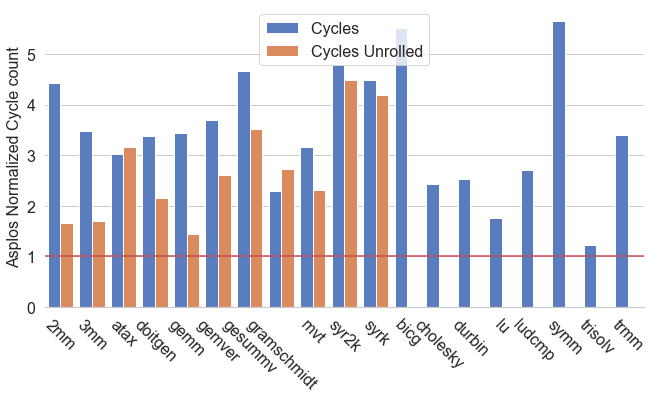

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
# unrolled_benches = data[data['type'] == 'Unrolled (Latency Sensitive)']['benchmark']
data = comp_data[comp_data['type'] != 'Latency Insensitive']
keep = ['benchmark', 'type', 'latency-norm']
data = data.drop(columns=data.columns.difference(keep))
data = data.melt(['benchmark', 'type'])
names = {'lut-norm': 'LUT', 'latency-norm': 'Cycles', 'Latency Sensitive': '', 'Unrolled (Latency Sensitive)': 'Unrolled'}
data['variable'] = data['variable'].apply(lambda x: names[x])
data['type'] = data['type'].apply(lambda x: names[x])
data['name'] = data['variable'] + ' ' + data['type']

g = sns.catplot(
    x="benchmark", 
    y="value", 
    hue="name", 
    data=data,
    kind="bar",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Asplos Normalized Cycle count", fontsize=fontsize)
g.set_xlabels("")
g.set_yticklabels(fontsize=fontsize)
g.set_xticklabels(rotation=-45, fontsize=fontsize)
g.axes[0,0].legend(loc='upper center', fontsize=fontsize).set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)
g.savefig('asplos-unrolled-lat-sen-cycles.pdf')

from scipy import stats
stats.gmean(data[data['name'] == 'Cycles ']['value'])

/home/samthomas/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:921: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(curr_labels, **kwargs)


1.3932618989677392

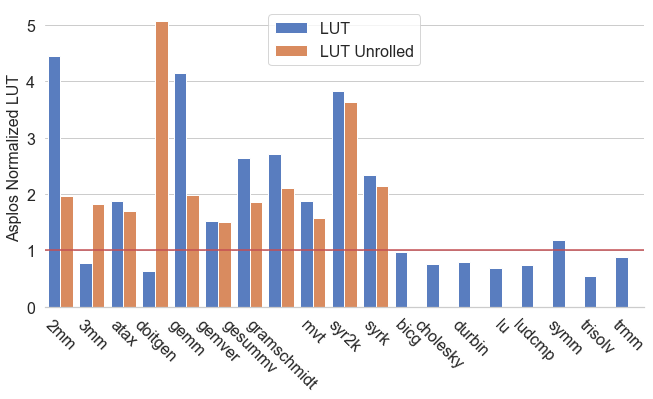

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
# unrolled_benches = data[data['type'] == 'Unrolled (Latency Sensitive)']['benchmark']
data = comp_data[comp_data['type'] != 'Latency Insensitive']
keep = ['benchmark', 'type', 'lut-norm']
data = data.drop(columns=data.columns.difference(keep))
data = data.melt(['benchmark', 'type'])
names = {'lut-norm': 'LUT', 'latency-norm': 'Cycles', 'Latency Sensitive': '', 'Unrolled (Latency Sensitive)': 'Unrolled'}
data['variable'] = data['variable'].apply(lambda x: names[x])
data['type'] = data['type'].apply(lambda x: names[x])
data['name'] = data['variable'] + ' ' + data['type']

g = sns.catplot(
    x="benchmark", 
    y="value", 
    hue="name", 
    data=data,
    kind="bar", 
    palette="muted",
    legend=False
)

g.despine(left=True)
g.set_ylabels("Asplos Normalized LUT", fontsize=fontsize)
g.set_xlabels("")
g.set_yticklabels(fontsize=fontsize)
g.set_xticklabels(rotation=-45, fontsize=fontsize)
g.axes[0,0].legend(loc='upper center', fontsize=fontsize).set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)
g.savefig('asplos-unrolled-lat-sen-lut.pdf')

from scipy import stats
stats.gmean(data['value'])

d = data.loc[data['name'] == 'LUT ']
stats.gmean(d['value'])

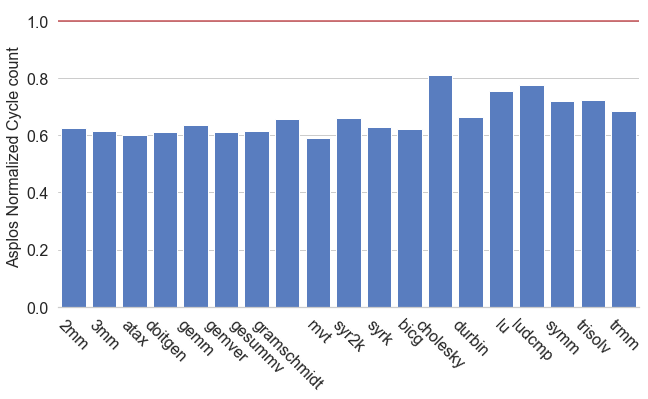

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

data = comp_data[comp_data["type"] != "Unrolled (Latency Sensitive)"]
keep = ['benchmark', 'type', 'latency-futil', 'lut-futil']
data = data.drop(columns=data.columns.difference(keep))
norm = data.loc[data['type'] == 'Latency Sensitive', 'latency-futil'].values / data.loc[data['type'] == 'Latency Insensitive', 'latency-futil'].values
norm = norm

data = data[data['type'] == 'Latency Sensitive']
data['Latency Sensitive Cycles'] = norm

g = sns.catplot(
    x="benchmark", 
    y="value",
    hue="variable", 
    data=data.drop(columns=['type', 'latency-futil', 'lut-futil']).melt(['benchmark']),
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Asplos Normalized Cycle count", fontsize=fontsize)
g.set_xlabels("")
g.set_xticklabels(rotation=-45, fontsize=fontsize)
g.fig.set_size_inches(10,5)

# g.set(ylim=(0, 1.1))
g.axes[0,0].axhline(1, color='r')
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(fontsize) # I hate this, but otherwise the axes would be wrong

g.savefig('asplos-norm-lat-sen-insen.pdf', dpi=400)

In [8]:
data = comp_data[comp_data["type"] != "Unrolled (Latency Sensitive)"]
keep = ['benchmark', 'type', 'latency-futil', 'lut-futil']
data = data.drop(columns=data.columns.difference(keep))
norm_by_sen = data.loc[data['type'] == 'Latency Insensitive', 'latency-futil'].values / data.loc[data['type'] == 'Latency Sensitive', 'latency-futil'].values
norm_by_base = data.loc[data['type'] == 'Latency Sensitive', 'latency-futil'].values / data.loc[data['type'] == 'Latency Insensitive', 'latency-futil'].values
diff = data.loc[data['type'] == 'Latency Insensitive', 'latency-futil'].values - data.loc[data['type'] == 'Latency Sensitive', 'latency-futil'].values
base = stats.gmean(data.loc[data['type'] == 'Latency Insensitive', 'latency-futil'].values)

from scipy import stats
print(stats.gmean(norm_by_sen - 1) * 100, "% faster")
print(stats.gmean(norm_by_base) * 100, "% of baseline")
print(stats.gmean(1 - norm_by_base) * 100, "% fewer than baseline")
print(stats.gmean(diff / base) * 100, "% cycles faster")

50.020998993735525 % faster
66.0140866904645 % of baseline
33.020905639160944 % fewer than baseline
33.02090563916092 % cycles faster


## Systolic array

In [9]:
# systolic_data = pd.read_csv('../systolic-experiments/scan/data.csv')
# systolic_lat = pd.read_csv('../systolic-experiments/scan/systolic.csv')
# hls = pd.read_csv('../results/17_21_55-08_2020/data.csv')
systolic_data = pd.read_csv('../asplos_data/systolic/data.csv')
systolic_lat = pd.read_csv('../asplos_data/systolic/systolic.csv')
hls = pd.read_csv('../asplos_data/systolic/hls.csv')


hls = hls[hls['type'] == 'hls'].sort_values(by='benchmark').reset_index(drop=True).drop([1]).reset_index(drop=True)
# Only the "futil" rows have valid data
systolic_data = systolic_data[systolic_data['type'] == 'futil'].sort_values(by='benchmark').drop(columns=['meet_timing', 'source', 'type']).reset_index(drop=True)
# Remove systolic array data for which VHLS implementation failed
systolic_data = systolic_data.drop([0, 2, 4, 6]).reset_index(drop=True)

systolic_data['latency'] = systolic_lat['latency']
systolic_data['type'] = 'Calyx'
hls['type'] = 'HLS'
systolic_data = systolic_data.merge(hls[['benchmark', 'lut', 'latency', 'type', 'dsp']], how='outer')

# Better names
systolic_data['benchmark'] = systolic_data['benchmark'].apply(lambda x: "{} x {}".format(x.split('_')[1], x.split('_')[1]))


systolic_data

,benchmark,lut,dsp,latency,type
0,2 x 2,528.0,12.0,26,Calyx
1,4 x 4,2219.0,48.0,77,Calyx
2,6 x 6,7851.0,108.0,132,Calyx
3,8 x 8,14827.0,192.0,191,Calyx
4,2 x 2,808.0,12.0,62,HLS
5,4 x 4,2387.0,48.0,322,HLS
6,6 x 6,4909.0,108.0,926,HLS
7,8 x 8,8443.0,192.0,2210,HLS


In [10]:
# geometric mean improvement lut
from scipy import stats
lut_norm = systolic_data[systolic_data['type'] == 'Calyx']['lut'].values / systolic_data[systolic_data['type'] == 'HLS']['lut'].values
lat_improv = systolic_data[systolic_data['type'] == 'HLS']['latency'].values / systolic_data[systolic_data['type'] == 'Calyx']['latency'].values

print('lat improvement', stats.gmean(lat_improv))
print('lut deprovement', stats.gmean(lut_norm))
lat_improv.mean()

lat improvement 5.3338999166966845
lut deprovement 1.1428887878008394


6.288066427464333

/home/samthomas/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:921: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(curr_labels, **kwargs)


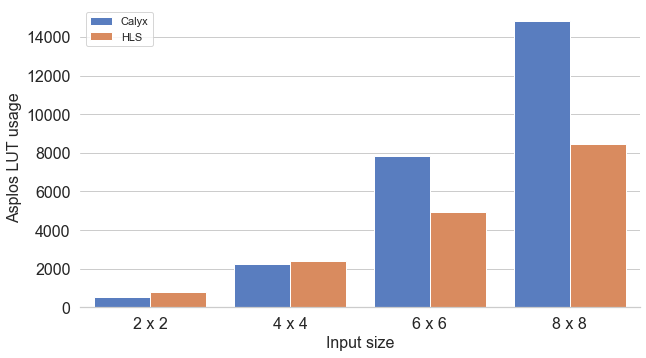

In [11]:
g = sns.catplot(
    x="benchmark", 
    y="lut", 
    hue="type", 
    data=systolic_data,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Asplos LUT usage", fontsize=fontsize)
g.set_xlabels("Input size", fontsize=fontsize)
g.set_yticklabels(fontsize=fontsize)
g.set_xticklabels(fontsize=fontsize)
g.axes[0,0].legend(loc='upper left',).set_title('')
g.fig.set_size_inches(10,5)
g.savefig('asplos-systolic-lut.pdf')

/home/samthomas/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:921: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(curr_labels, **kwargs)


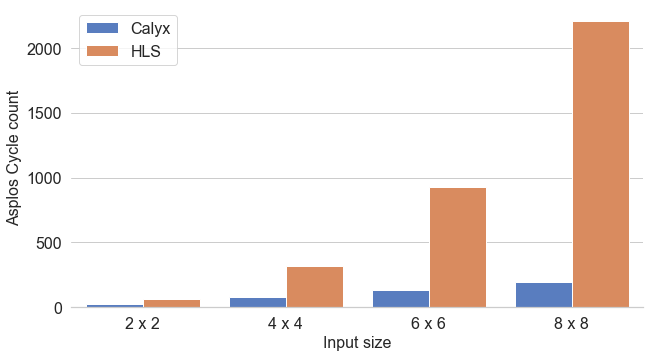

In [12]:
g = sns.catplot(
    x="benchmark", 
    y="latency", 
    hue="type", 
    data=systolic_data,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Asplos Cycle count", fontsize=fontsize)
g.set_xlabels("Input size", fontsize=fontsize)
g.set_yticklabels(fontsize=fontsize)
g.set_xticklabels(fontsize=fontsize)
g.axes[0,0].legend(loc='upper left', fontsize=fontsize).set_title('')
g.fig.set_size_inches(10,5)
g.savefig('asplos-systolic-lat.pdf')